## Interaktive Tabellen-Details

Hier können Sie Details zu jeder einzelnen Tabelle abrufen:

In [53]:
import duckdb
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch
import numpy as np

# Verbindung zur Datenbank
conn = duckdb.connect('mimic4.db', read_only=True)

# Schema-Informationen abrufen
schema_info = {}

# Alle relevanten Schemas
schemas = ['mimiciv_hosp', 'mimiciv_icu']

for schema in schemas:
    # Tabellen und Spalten für jedes Schema abrufen
    query = f"""
    SELECT 
        table_name,
        column_name,
        data_type,
        is_nullable
    FROM information_schema.columns
    WHERE table_schema = '{schema}'
    ORDER BY table_name, ordinal_position
    """
    
    result = conn.execute(query).fetchall()
    
    # Daten strukturieren
    tables = {}
    for table_name, column_name, data_type, is_nullable in result:
        if table_name not in tables:
            tables[table_name] = []
        tables[table_name].append({
            'name': column_name,
            'type': data_type,
            'nullable': is_nullable
        })
    
    schema_info[schema] = tables

conn.close()

print("Datenbank-Struktur geladen!")
print(f"\nGefundene Schemas: {list(schema_info.keys())}")
for schema, tables in schema_info.items():
    print(f"  {schema}: {len(tables)} Tabellen")

Datenbank-Struktur geladen!

Gefundene Schemas: ['mimiciv_hosp', 'mimiciv_icu']
  mimiciv_hosp: 22 Tabellen
  mimiciv_icu: 9 Tabellen


In [54]:
# Statistiken und Zusammenfassung
print("\\n" + "="*60)
print("MIMIC-IV DATENBANK ZUSAMMENFASSUNG")
print("="*60)

total_tables = 0
total_columns = 0

for schema_name, tables in schema_info.items():
    print(f"\\n{schema_name.upper()}:")
    print(f"  Anzahl Tabellen: {len(tables)}")
    
    schema_columns = sum(len(cols) for cols in tables.values())
    print(f"  Gesamte Spalten: {schema_columns}")
    
    # Größte Tabellen
    print(f"  Größte Tabellen (nach Spaltenanzahl):")
    sorted_tables = sorted(tables.items(), key=lambda x: len(x[1]), reverse=True)[:5]
    for table_name, columns in sorted_tables:
        print(f"    - {table_name}: {len(columns)} Spalten")
    
    total_tables += len(tables)
    total_columns += schema_columns

print(f"\\n{'='*60}")
print(f"GESAMT:")
print(f"  Schemas: {len(schema_info)}")
print(f"  Tabellen: {total_tables}")
print(f"  Spalten: {total_columns}")
print(f"{'='*60}")

\n============================================================
MIMIC-IV DATENBANK ZUSAMMENFASSUNG
\nMIMICIV_HOSP:
  Anzahl Tabellen: 22
  Gesamte Spalten: 229
  Größte Tabellen (nach Spaltenanzahl):
    - emar_detail: 33 Spalten
    - pharmacy: 27 Spalten
    - microbiologyevents: 25 Spalten
    - prescriptions: 21 Spalten
    - admissions: 16 Spalten
\nMIMICIV_ICU:
  Anzahl Tabellen: 9
  Gesamte Spalten: 113
  Größte Tabellen (nach Spaltenanzahl):
    - inputevents: 26 Spalten
    - procedureevents: 22 Spalten
    - ingredientevents: 17 Spalten
    - chartevents: 11 Spalten
    - datetimeevents: 10 Spalten
\n============================================================
GESAMT:
  Schemas: 2
  Tabellen: 31
  Spalten: 342


In [67]:
# Detaillierte Tabellen-Visualisierung für ein spezifisches Schema
def visualize_table_details_multicolumn(schema_name, tables):
    """Erstellt eine detaillierte Visualisierung mit mehrspaltiger Spalten-Darstellung"""
    
    table_list = sorted(tables.items())
    n_tables = len(table_list)
    
    # Layout berechnen (2 Spalten für bessere Breite)
    cols = 2
    rows = (n_tables + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 5))
    if rows == 1:
        axes = axes.reshape(1, -1)
    elif cols == 1:
        axes = axes.reshape(-1, 1)
    
    fig.suptitle(f'Schema: {schema_name.upper()} - Alle Tabellen mit allen Spalten', 
                 fontsize=18, fontweight='bold', y=0.995)
    
    # Farbe basierend auf Schema
    schema_color = '#3498db' if 'hosp' in schema_name else '#e74c3c'
    
    for idx, (table_name, columns) in enumerate(table_list):
        row = idx // cols
        col = idx % cols
        ax = axes[row, col]
        
        ax.set_xlim(0, 10)
        ax.set_ylim(0, 10)
        ax.axis('off')
        
        # Tabellen-Header
        header = FancyBboxPatch(
            (0.3, 8.7), 9.4, 1.0,
            boxstyle="round,pad=0.05",
            edgecolor=schema_color,
            facecolor=schema_color,
            alpha=0.8,
            linewidth=2
        )
        ax.add_patch(header)
        
        ax.text(5, 9.2, table_name, 
                ha='center', va='center', fontsize=13, 
                fontweight='bold', color='white')
        ax.text(5, 8.9, f'{len(columns)} Spalten', 
                ha='center', va='center', fontsize=9, 
                style='italic', color='white', alpha=0.9)
        
        # Spalten in 2 Spalten anordnen für mehr Platz
        n_cols_display = 2
        col_width = 4.5
        
        # Berechne wie viele Zeilen wir brauchen
        items_per_column = (len(columns) + n_cols_display - 1) // n_cols_display
        
        y_start = 8.4
        line_height = 0.32
        
        for i, col_info in enumerate(columns):
            # Berechne Position (welche Spalte und welche Zeile)
            display_col = i // items_per_column
            display_row = i % items_per_column
            
            if display_col >= n_cols_display:
                break  # Falls wir aus Platzgründen abbrechen müssen
            
            x_pos = 0.5 + (display_col * col_width)
            y_pos = y_start - (display_row * line_height)
            
            # Prüfen ob wir noch im sichtbaren Bereich sind
            if y_pos < 0.8:
                continue
            
            # Spaltenname kürzen falls nötig
            col_name = col_info['name']
            if len(col_name) > 20:
                col_name = col_name[:17] + '...'
            
            # Symbol für Nullable
            nullable_symbol = '○' if col_info['nullable'] == 'YES' else '●'
            
            # Datentyp kürzen
            dtype = col_info['type']
            if len(dtype) > 10:
                dtype = dtype[:7] + '...'
            
            # Text mit kleiner Schrift
            ax.text(x_pos, y_pos, f"{nullable_symbol} {col_name}",
                    ha='left', va='top', fontsize=6.5,
                    fontfamily='monospace')
            ax.text(x_pos + 4.0, y_pos, dtype,
                    ha='right', va='top', fontsize=6,
                    color='gray', fontfamily='monospace')
        
        # Legende für Nullable
        ax.text(0.5, 0.3, '● = NOT NULL    ○ = NULLABLE',
                ha='left', va='bottom', fontsize=6.5,
                color='gray', style='italic')
    
    # Leere Subplots ausblenden
    for idx in range(n_tables, rows * cols):
        row = idx // cols
        col = idx % cols
        axes[row, col].axis('off')
    
    plt.tight_layout()
    return fig

Erstelle verbesserte Visualisierung für mimiciv_hosp (alle Spalten)...


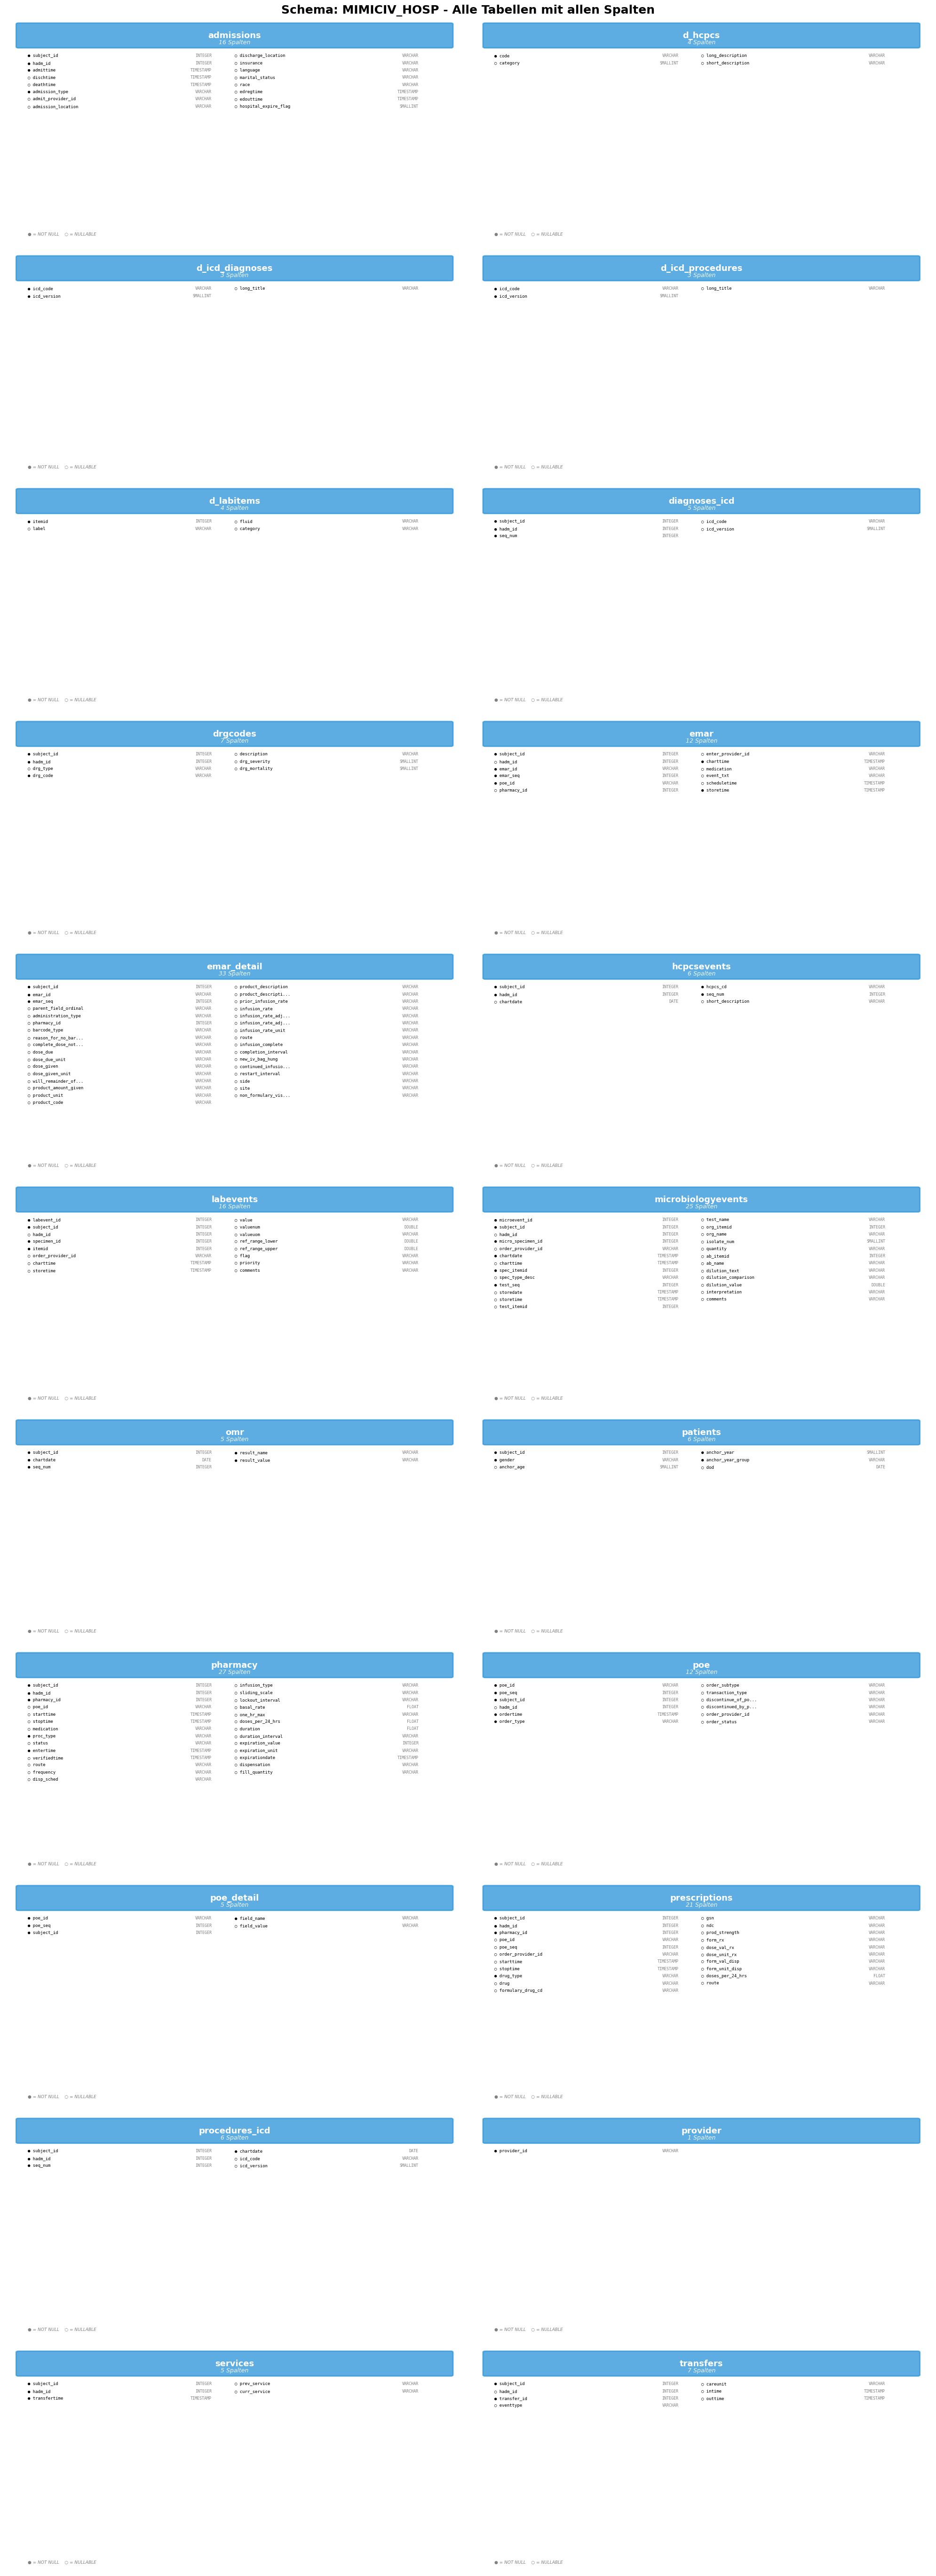

In [68]:

# Visualisierung mit allen Spalten erstellen
print("Erstelle verbesserte Visualisierung für mimiciv_hosp (alle Spalten)...")
fig_hosp_full = visualize_table_details_multicolumn('mimiciv_hosp', schema_info['mimiciv_hosp'])
plt.show()

Erstelle verbesserte Visualisierung für mimiciv_icu (alle Spalten)...


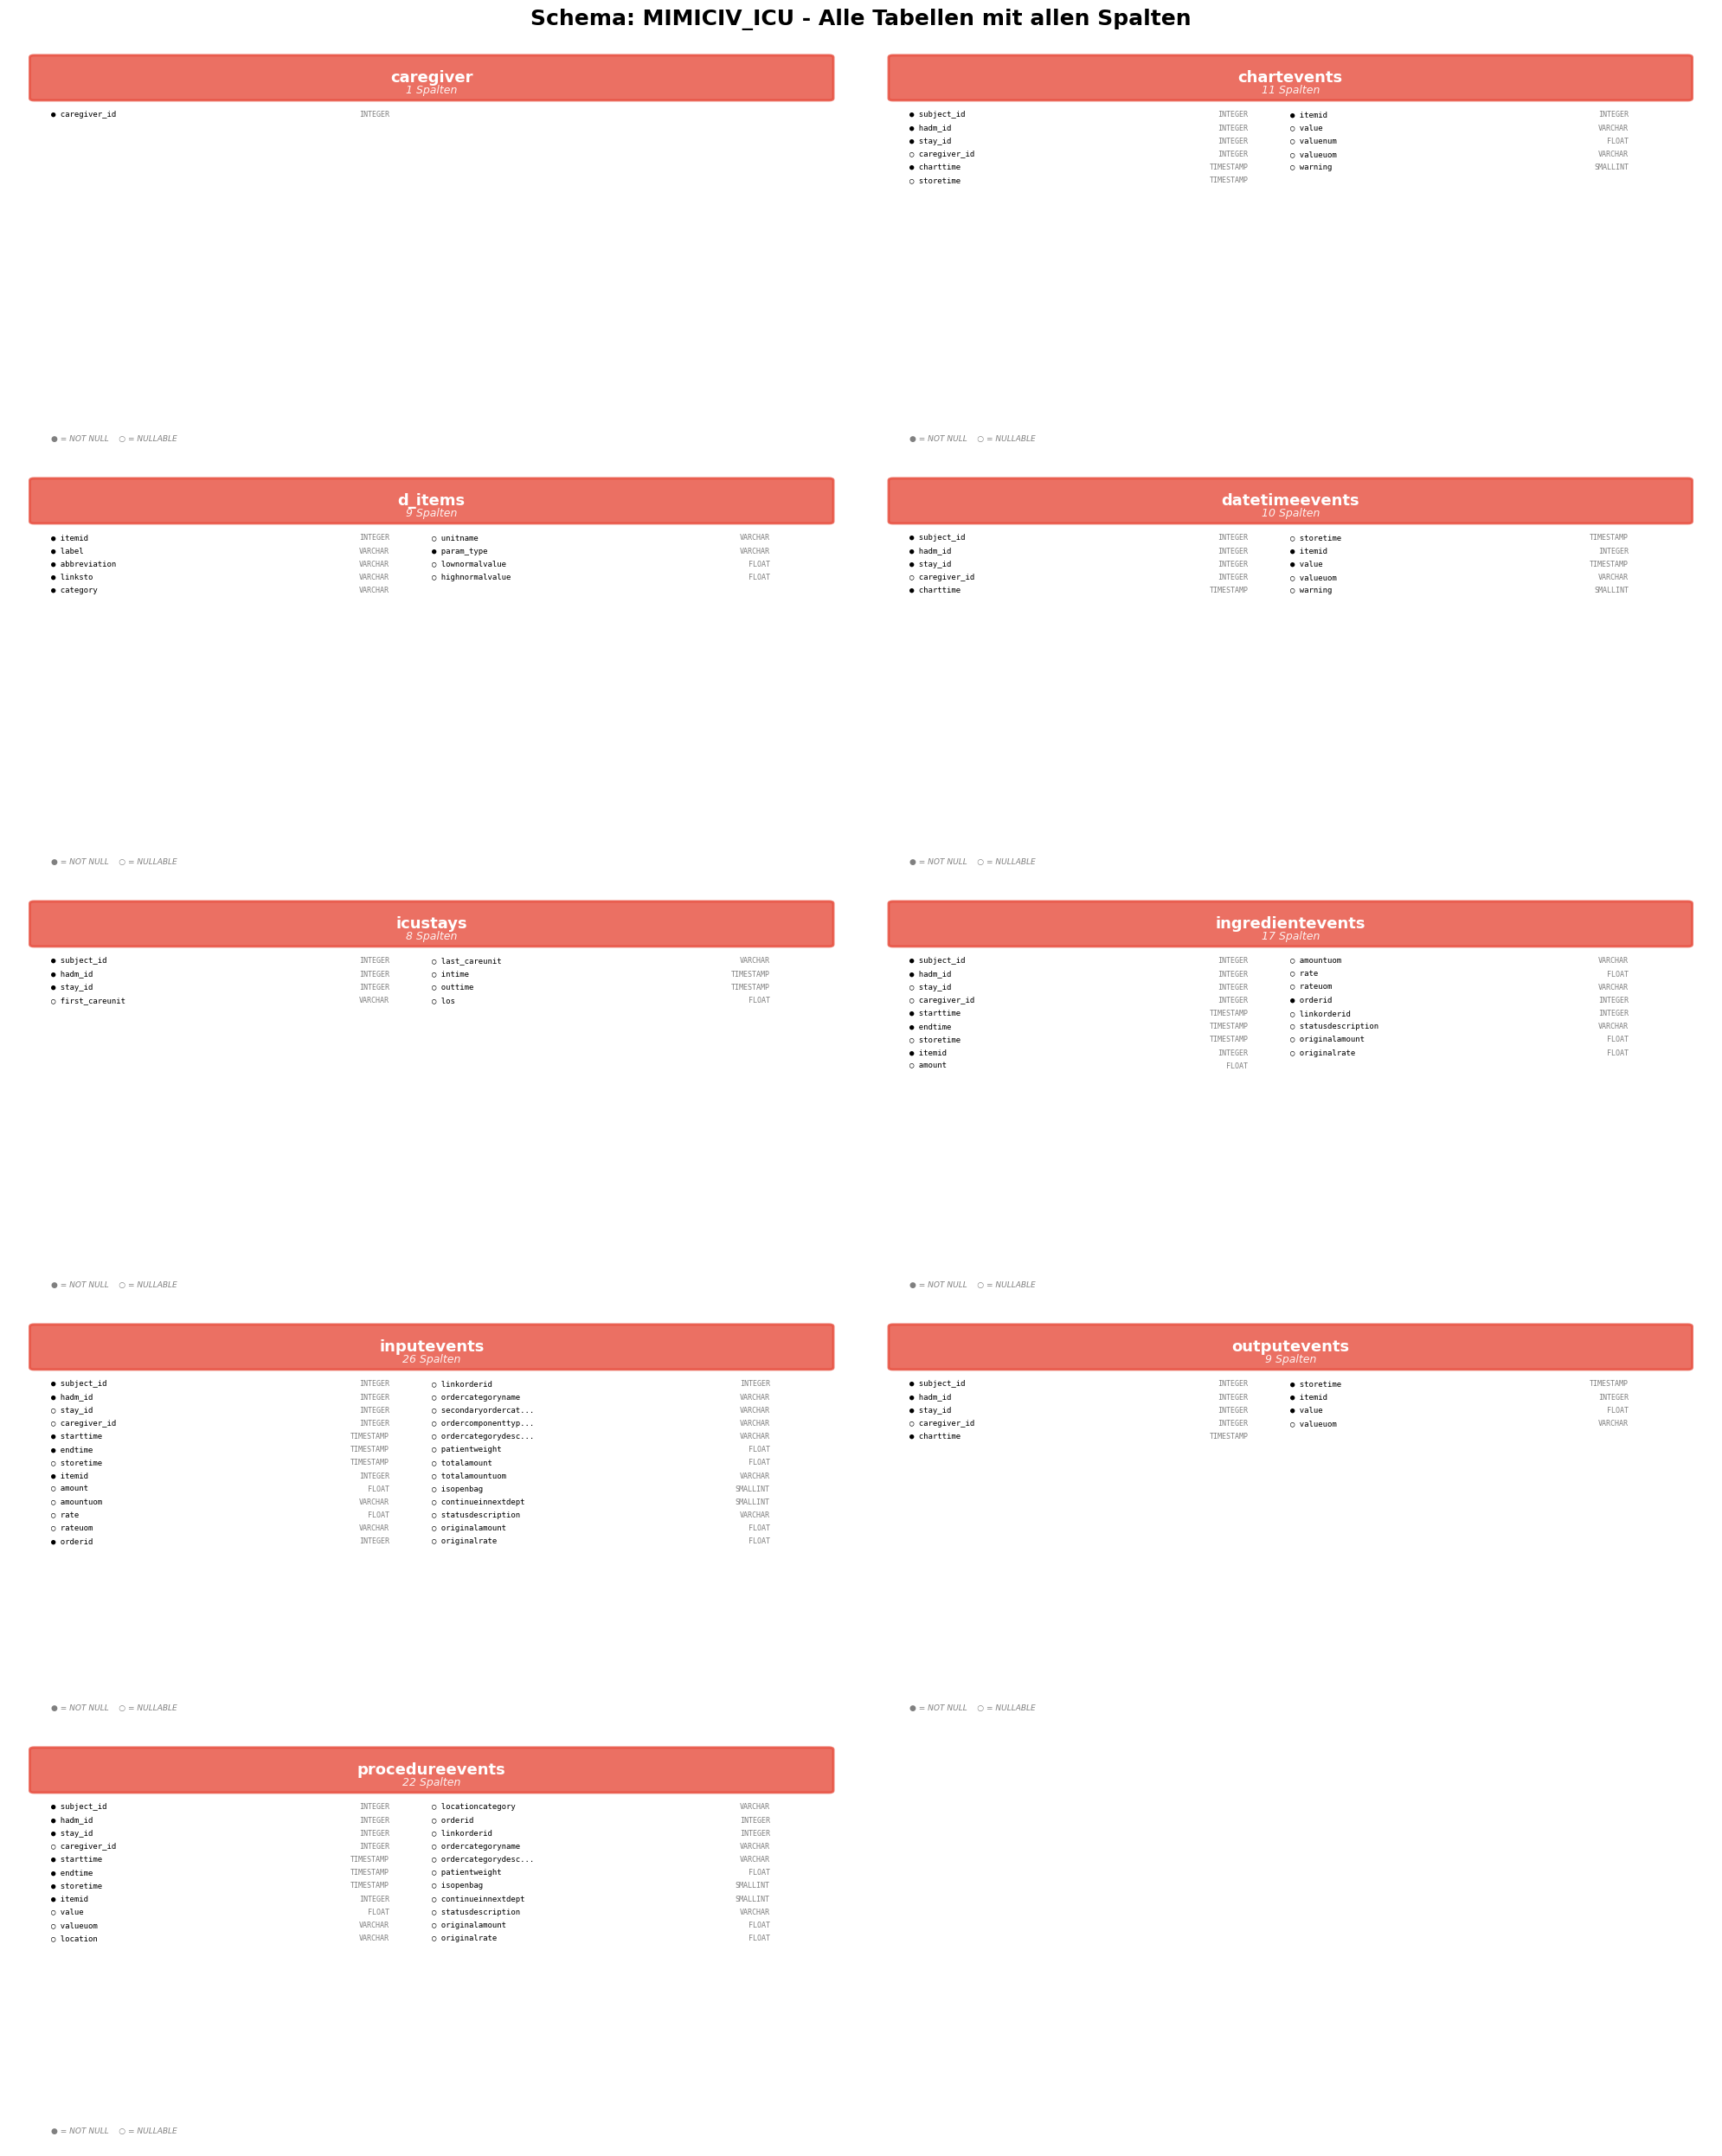

In [69]:
print("Erstelle verbesserte Visualisierung für mimiciv_icu (alle Spalten)...")
fig_icu_full = visualize_table_details_multicolumn('mimiciv_icu', schema_info['mimiciv_icu'])
plt.show()

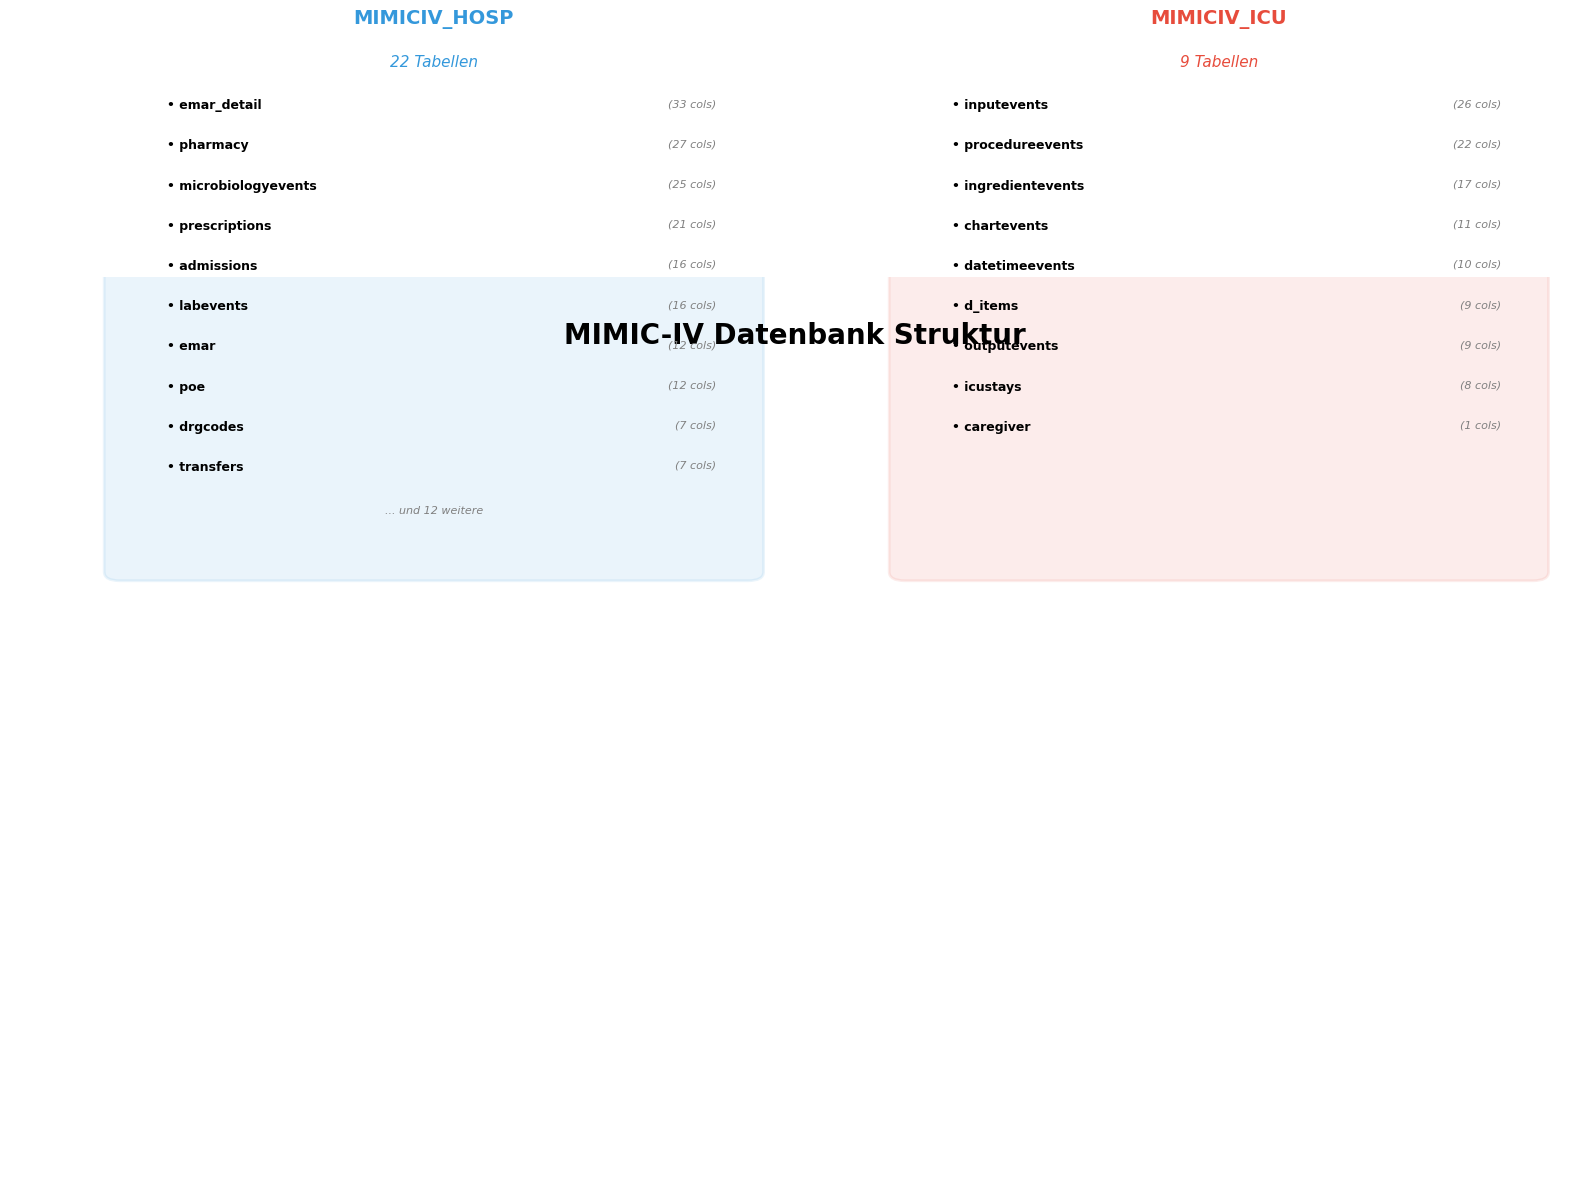


=== Detaillierte Statistiken ===


In [70]:
# Funktion zum Erstellen einer kompakten Schema-Visualisierung
def create_schema_overview(schema_info):
    """Erstellt eine Übersichts-Visualisierung aller Schemas"""
    
    fig, ax = plt.subplots(figsize=(16, 12))
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)
    ax.axis('off')
    
    # Farben für verschiedene Schemas
    colors = {
        'mimiciv_hosp': '#3498db',  # Blau
        'mimiciv_icu': '#e74c3c'    # Rot
    }
    
    # Position für jedes Schema
    schema_positions = {
        'mimiciv_hosp': (1, 7),
        'mimiciv_icu': (6, 7)
    }
    
    # Titel
    ax.text(5, 9.5, 'MIMIC-IV Datenbank Struktur', 
            ha='center', va='top', fontsize=20, fontweight='bold')
    
    for schema_name, tables in schema_info.items():
        x, y = schema_positions[schema_name]
        color = colors[schema_name]
        
        # Schema-Box
        schema_box = FancyBboxPatch(
            (x - 0.3, y - 0.3), 4, 6.5,
            boxstyle="round,pad=0.1",
            edgecolor=color,
            facecolor=color,
            alpha=0.1,
            linewidth=2
        )
        ax.add_patch(schema_box)
        
        # Schema-Name
        ax.text(x + 1.7, y + 6, schema_name.upper(),
                ha='center', va='top', fontsize=14, fontweight='bold',
                color=color)
        
        # Tabellen-Info
        ax.text(x + 1.7, y + 5.5, f'{len(tables)} Tabellen',
                ha='center', va='top', fontsize=11, style='italic',
                color=color)
        
        # Top 10 Tabellen mit Spaltenanzahl
        sorted_tables = sorted(tables.items(), key=lambda x: len(x[1]), reverse=True)[:10]
        
        y_offset = y + 5
        for i, (table_name, columns) in enumerate(sorted_tables):
            y_pos = y_offset - (i * 0.45)
            
            # Tabellen-Name
            ax.text(x, y_pos, f"• {table_name}",
                    ha='left', va='top', fontsize=9,
                    fontweight='bold')
            
            # Spaltenanzahl
            ax.text(x + 3.5, y_pos, f"({len(columns)} cols)",
                    ha='right', va='top', fontsize=8,
                    color='gray', style='italic')
        
        # Hinweis auf weitere Tabellen
        if len(tables) > 10:
            ax.text(x + 1.7, y_pos - 0.5, 
                    f'... und {len(tables) - 10} weitere',
                    ha='center', va='top', fontsize=8, 
                    style='italic', color='gray')
    
    plt.tight_layout()
    return fig

# Visualisierung erstellen
fig = create_schema_overview(schema_info)
plt.show()

print("\n=== Detaillierte Statistiken ===")

# MIMIC-IV Datenbank-Schema Visualisierung

In [71]:
def show_table_info(schema_name, table_name):
    """Zeigt detaillierte Informationen über eine spezifische Tabelle"""
    
    if schema_name not in schema_info:
        print(f"Schema '{schema_name}' nicht gefunden!")
        print(f"Verfügbare Schemas: {list(schema_info.keys())}")
        return
    
    if table_name not in schema_info[schema_name]:
        print(f"Tabelle '{table_name}' in Schema '{schema_name}' nicht gefunden!")
        print(f"Verfügbare Tabellen: {list(schema_info[schema_name].keys())}")
        return
    
    columns = schema_info[schema_name][table_name]
    
    print(f"\\n{'='*70}")
    print(f"Schema: {schema_name} | Tabelle: {table_name}")
    print(f"{'='*70}")
    print(f"Anzahl Spalten: {len(columns)}")
    print(f"\\n{'Spaltenname':<30} {'Datentyp':<15} {'Nullable'}")
    print(f"{'-'*30} {'-'*15} {'-'*8}")
    
    for col in columns:
        nullable = "✓" if col['nullable'] == 'YES' else "✗"
        print(f"{col['name']:<30} {col['type']:<15} {nullable}")
    
    print(f"{'='*70}")

# Beispiel: Details einer Tabelle anzeigen
show_table_info('mimiciv_hosp', 'patients')

\n======================================================================
Schema: mimiciv_hosp | Tabelle: patients
Anzahl Spalten: 6
\nSpaltenname                    Datentyp        Nullable
------------------------------ --------------- --------
subject_id                     INTEGER         ✗
gender                         VARCHAR         ✗
anchor_age                     SMALLINT        ✓
anchor_year                    SMALLINT        ✗
anchor_year_group              VARCHAR         ✗
dod                            DATE            ✓


In [72]:
# Weitere Beispiele
show_table_info('mimiciv_hosp', 'admissions')
show_table_info('mimiciv_icu', 'chartevents')

\n======================================================================
Schema: mimiciv_hosp | Tabelle: admissions
Anzahl Spalten: 16
\nSpaltenname                    Datentyp        Nullable
------------------------------ --------------- --------
subject_id                     INTEGER         ✗
hadm_id                        INTEGER         ✗
admittime                      TIMESTAMP       ✗
dischtime                      TIMESTAMP       ✓
deathtime                      TIMESTAMP       ✓
admission_type                 VARCHAR         ✗
admit_provider_id              VARCHAR         ✓
admission_location             VARCHAR         ✓
discharge_location             VARCHAR         ✓
insurance                      VARCHAR         ✓
language                       VARCHAR         ✓
marital_status                 VARCHAR         ✓
race                           VARCHAR         ✓
edregtime                      TIMESTAMP       ✓
edouttime                      TIMESTAMP       ✓
hospital_expire_

# MIMIC-IV Datenbank Exploration mit DuckDB

Dieses Notebook ermöglicht die Exploration der MIMIC-IV Datenbank mit DuckDB.

## Setup und Verbindung zur Datenbank

In [2]:
import duckdb
import pandas as pd

# Verbindung zur MIMIC-IV DuckDB Datenbank herstellen
conn = duckdb.connect('mimic4.db', read_only=True)
print("Verbindung zur Datenbank hergestellt!")

Verbindung zur Datenbank hergestellt!


## Datenbank-Übersicht

In [ ]:
# Alle Schemas anzeigen
schemas = conn.execute("SELECT schema_name FROM information_schema.schemata").df()
print("Verfügbare Schemas:")
display(schemas)

Verfügbare Schemas:


,schema_name
0,main
1,mimiciv_derived
2,mimiciv_hosp
3,mimiciv_icu
4,information_schema
5,main
6,pg_catalog
7,main


In [4]:
# Alle Tabellen in den MIMIC-IV Schemas anzeigen
tables = conn.execute("""
    SELECT table_schema, table_name 
    FROM information_schema.tables 
    WHERE table_schema LIKE 'mimiciv_%'
    ORDER BY table_schema, table_name
""").df()

print(f"Anzahl der Tabellen: {len(tables)}")
display(tables)

Anzahl der Tabellen: 31


,table_schema,table_name
0,mimiciv_hosp,admissions
1,mimiciv_hosp,d_hcpcs
2,mimiciv_hosp,d_icd_diagnoses
3,mimiciv_hosp,d_icd_procedures
4,mimiciv_hosp,d_labitems
5,mimiciv_hosp,diagnoses_icd
6,mimiciv_hosp,drgcodes
7,mimiciv_hosp,emar
8,mimiciv_hosp,emar_detail
9,mimiciv_hosp,hcpcsevents


## Tabellen im Hospital (hosp) Schema

In [5]:
# Hospital-Tabellen anzeigen
hosp_tables = conn.execute("""
    SELECT table_name 
    FROM information_schema.tables 
    WHERE table_schema = 'mimiciv_hosp'
    ORDER BY table_name
""").df()

print("Tabellen im mimiciv_hosp Schema:")
display(hosp_tables)

Tabellen im mimiciv_hosp Schema:


,table_name
0,admissions
1,d_hcpcs
2,d_icd_diagnoses
3,d_icd_procedures
4,d_labitems
5,diagnoses_icd
6,drgcodes
7,emar
8,emar_detail
9,hcpcsevents


## Tabellen im ICU Schema

In [6]:
# ICU-Tabellen anzeigen
icu_tables = conn.execute("""
    SELECT table_name 
    FROM information_schema.tables 
    WHERE table_schema = 'mimiciv_icu'
    ORDER BY table_name
""").df()

print("Tabellen im mimiciv_icu Schema:")
display(icu_tables)

Tabellen im mimiciv_icu Schema:


,table_name
0,caregiver
1,chartevents
2,d_items
3,datetimeevents
4,icustays
5,ingredientevents
6,inputevents
7,outputevents
8,procedureevents


## Spalten einer Tabelle anzeigen

Beispiel: patients Tabelle

In [7]:
# Spalten der patients Tabelle anzeigen
patients_columns = conn.execute("""
    SELECT column_name, data_type, is_nullable
    FROM information_schema.columns
    WHERE table_schema = 'mimiciv_hosp' AND table_name = 'patients'
    ORDER BY ordinal_position
""").df()

print("Spalten in mimiciv_hosp.patients:")
display(patients_columns)

Spalten in mimiciv_hosp.patients:


,column_name,data_type,is_nullable
0,subject_id,INTEGER,NO
1,gender,VARCHAR,NO
2,anchor_age,SMALLINT,YES
3,anchor_year,SMALLINT,NO
4,anchor_year_group,VARCHAR,NO
5,dod,DATE,YES


## Grundlegende Statistiken

In [8]:
# Anzahl der Patienten
patient_count = conn.execute("SELECT COUNT(*) as count FROM mimiciv_hosp.patients").df()
print(f"Anzahl der Patienten: {patient_count['count'].values[0]:,}")

# Anzahl der Aufnahmen (admissions)
admission_count = conn.execute("SELECT COUNT(*) as count FROM mimiciv_hosp.admissions").df()
print(f"Anzahl der Aufnahmen: {admission_count['count'].values[0]:,}")

Anzahl der Patienten: 364,627
Anzahl der Aufnahmen: 546,028


## Beispiel-Abfragen

In [9]:
# Erste 10 Patienten anzeigen
sample_patients = conn.execute("""
    SELECT * 
    FROM mimiciv_hosp.patients 
    LIMIT 10
""").df()

print("Beispiel-Patienten:")
display(sample_patients)

Beispiel-Patienten:


,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10000032,F,52,2180,2014 - 2016,2180-09-09
1,10000048,F,23,2126,2008 - 2010,NaT
2,10000058,F,33,2168,2020 - 2022,NaT
3,10000068,F,19,2160,2008 - 2010,NaT
4,10000084,M,72,2160,2017 - 2019,2161-02-13
5,10000102,F,27,2136,2008 - 2010,NaT
6,10000108,M,25,2163,2014 - 2016,NaT
7,10000115,M,24,2154,2017 - 2019,NaT
8,10000117,F,48,2174,2008 - 2010,NaT
9,10000161,M,60,2163,2020 - 2022,NaT


Geschlechterverteilung:


,gender,count
0,F,191984
1,M,172643


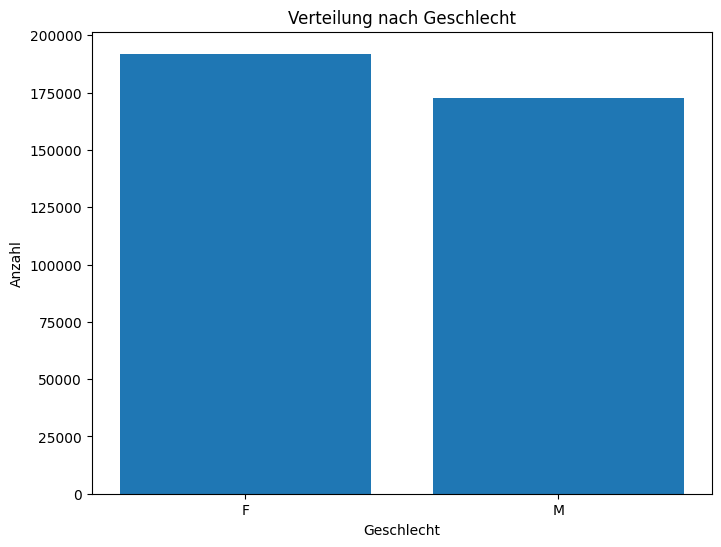

In [11]:
# Geschlechterverteilung
gender_dist = conn.execute("""
    SELECT gender, COUNT(*) as count
    FROM mimiciv_hosp.patients
    GROUP BY gender
    ORDER BY count DESC
""").df()

print("Geschlechterverteilung:")
display(gender_dist)

# Visualisierung
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.bar(gender_dist['gender'], gender_dist['count'])
plt.xlabel('Geschlecht')
plt.ylabel('Anzahl')
plt.title('Verteilung nach Geschlecht')
plt.show()

In [12]:
# Aufnahme-Typen
admission_types = conn.execute("""
    SELECT admission_type, COUNT(*) as count
    FROM mimiciv_hosp.admissions
    GROUP BY admission_type
    ORDER BY count DESC
""").df()

print("Aufnahme-Typen:")
display(admission_types)

Aufnahme-Typen:


,admission_type,count
0,EW EMER.,177459
1,EU OBSERVATION,119456
2,OBSERVATION ADMIT,84437
3,URGENT,54929
4,SURGICAL SAME DAY ADMISSION,42898
5,DIRECT OBSERVATION,24551
6,DIRECT EMER.,21973
7,ELECTIVE,13130
8,AMBULATORY OBSERVATION,7195


In [13]:
# Durchschnittliche Verweildauer (in Tagen)
length_of_stay = conn.execute("""
    SELECT 
        AVG(EXTRACT(EPOCH FROM (dischtime - admittime)) / 86400) as avg_los_days,
        MIN(EXTRACT(EPOCH FROM (dischtime - admittime)) / 86400) as min_los_days,
        MAX(EXTRACT(EPOCH FROM (dischtime - admittime)) / 86400) as max_los_days,
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY EXTRACT(EPOCH FROM (dischtime - admittime)) / 86400) as median_los_days
    FROM mimiciv_hosp.admissions
    WHERE dischtime IS NOT NULL
""").df()

print("Verweildauer-Statistiken (in Tagen):")
display(length_of_stay)

Verweildauer-Statistiken (in Tagen):


,avg_los_days,min_los_days,max_los_days,median_los_days
0,4.761742,-0.945139,515.5625,2.818056


## ICU Aufenthalte

In [18]:
# ICU Aufenthalte zählen
icu_stays = conn.execute("SELECT COUNT(*) as count FROM mimiciv_icu.icustays").df()
print(f"Anzahl der ICU-Aufenthalte: {icu_stays['count'].values[0]:,}")

# Beispiel ICU-Daten
sample_icu = conn.execute("""
    SELECT * 
    FROM mimiciv_icu.icustays 
""").df()

display(sample_icu)

Anzahl der ICU-Aufenthalte: 94,458


,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los
0,10000032,29079034,39553978,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266
1,10000690,25860671,37081114,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2150-11-02 19:37:00,2150-11-06 17:03:17,3.893252
2,10000980,26913865,39765666,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2189-06-27 08:42:00,2189-06-27 20:38:27,0.497535
3,10001217,24597018,37067082,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-11-20 19:18:02,2157-11-21 22:08:00,1.118032
4,10001217,27703517,34592300,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-12-19 15:42:24,2157-12-20 14:27:41,0.948113
...,...,...,...,...,...,...,...,...
94453,19999442,26785317,32336619,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2148-11-19 14:23:43,2148-11-26 13:12:15,6.950370
94454,19999625,25304202,31070865,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical/Surgical Intensive Care Unit (MICU/SICU),2139-10-10 19:18:00,2139-10-11 18:21:28,0.960741
94455,19999828,25744818,36075953,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2149-01-08 18:12:00,2149-01-10 13:11:02,1.790995
94456,19999840,21033226,38978960,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2164-09-12 09:26:28,2164-09-17 16:35:15,5.297766


## Eigene Abfragen

Nutze die folgende Zelle für eigene SQL-Abfragen:

In [16]:
# Eigene Abfrage hier einfügen
custom_query = """
    -- Beispiel: Top 10 häufigste Diagnosen
    SELECT icd_code, icd_version, COUNT(*) as count
    FROM mimiciv_hosp.diagnoses_icd
    GROUP BY icd_code, icd_version
    ORDER BY count DESC
"""

result = conn.execute(custom_query).df()
display(result)

,icd_code,icd_version,count
0,4019,9,102368
1,E785,10,84570
2,I10,10,83775
3,2724,9,67293
4,Z87891,10,62806
...,...,...,...
28578,S66523A,10,1
28579,M4819,10,1
28580,Z1832,10,1
28581,T8583XA,10,1


## Alle Diagnosen von Patienten die über die Notaufnahme kamen

In [49]:
# Alle ICD-Diagnosen von Notaufnahme-Patienten mit Häufigkeit
ed_diagnoses = conn.execute("""
    WITH ed_admissions AS (
        SELECT DISTINCT hadm_id, subject_id
        FROM mimiciv_hosp.admissions
        WHERE admission_type IN ('AMBULATORY OBSERVATION', 'DIRECT EMER.', 'URGENT', 'EW EMER.', 'DIRECT OBSERVATION', 'EU OBSERVATION', 'OBSERVATION ADMIT')
    )
    SELECT
        d.icd_code,
        d.icd_version,
        dd.long_title as diagnosis_description,
        COUNT(*) as frequency,
        COUNT(DISTINCT ed.subject_id) as unique_patients,
        COUNT(DISTINCT ed.hadm_id) as unique_admissions
    FROM mimiciv_hosp.diagnoses_icd d
    INNER JOIN ed_admissions ed ON d.hadm_id = ed.hadm_id
    LEFT JOIN mimiciv_hosp.d_icd_diagnoses dd ON d.icd_code = dd.icd_code AND d.icd_version = dd.icd_version
    GROUP BY d.icd_code, d.icd_version, dd.long_title
    ORDER BY frequency DESC
""").df()

print(f"Gesamtanzahl unterschiedlicher Diagnosen bei ED-Patienten: {len(ed_diagnoses):,}")
print(f"\nTop 50 häufigste Diagnosen:")
print("="*100)
display(ed_diagnoses.head(50))

Gesamtanzahl unterschiedlicher Diagnosen bei ED-Patienten: 27,967

Top 50 häufigste Diagnosen:


,icd_code,icd_version,diagnosis_description,frequency,unique_patients,unique_admissions
0,4019,9,Unspecified essential hypertension,89309,47620,89303
1,E785,10,None,73850,40734,73848
2,I10,10,None,72602,43882,72601
3,2724,9,Other and unspecified hyperlipidemia,58734,31454,58730
4,Z87891,10,Personal history of nicotine dependence,54326,28987,54323
5,K219,10,None,48929,26590,48927
6,53081,9,None,42254,22268,42250
7,25000,9,Diabetes mellitus without mention of complicat...,38440,18757,38439
8,F329,10,None,38421,21519,38421
9,I2510,10,None,37493,19023,37491


## 

## Patienten aus der Notaufnahme (Emergency Department)

In [23]:
# Zunächst: Welche admission_types und admission_locations gibt es?
admission_info = conn.execute("""
    SELECT 
        admission_type,
        admission_location,
        COUNT(*) as count
    FROM mimiciv_hosp.admissions
    WHERE admission_location LIKE '%EMERGENCY%' OR admission_type LIKE '%EMER%'
    GROUP BY admission_type, admission_location
    ORDER BY count DESC
""").df()

print("Notaufnahme-bezogene Aufnahmen:")
display(admission_info)

Notaufnahme-bezogene Aufnahmen:


,admission_type,admission_location,count
0,EW EMER.,EMERGENCY ROOM,136883
1,EU OBSERVATION,EMERGENCY ROOM,84018
2,OBSERVATION ADMIT,EMERGENCY ROOM,22026
3,DIRECT EMER.,PHYSICIAN REFERRAL,16289
4,EW EMER.,TRANSFER FROM HOSPITAL,11924
5,EW EMER.,PHYSICIAN REFERRAL,9966
6,EW EMER.,WALK-IN/SELF REFERRAL,9138
7,DIRECT EMER.,CLINIC REFERRAL,5671
8,EW EMER.,PROCEDURE SITE,3553
9,EW EMER.,PACU,2358


In [24]:
# Alle Patienten die mindestens einmal über die Notaufnahme aufgenommen wurden
ed_patients = conn.execute("""
    SELECT DISTINCT
        p.subject_id,
        p.gender,
        p.anchor_age,
        p.anchor_year_group,
        p.dod,
        COUNT(DISTINCT a.hadm_id) as total_admissions,
        SUM(CASE WHEN (a.admission_location LIKE '%EMERGENCY%' OR a.admission_type LIKE '%EMER%') 
            THEN 1 ELSE 0 END) as ed_admissions
    FROM mimiciv_hosp.patients p
    INNER JOIN mimiciv_hosp.admissions a ON p.subject_id = a.subject_id
    WHERE a.admission_location LIKE '%EMERGENCY%' OR a.admission_type LIKE '%EMER%'
    GROUP BY p.subject_id, p.gender, p.anchor_age, p.anchor_year_group, p.dod
    ORDER BY ed_admissions DESC, p.subject_id
""").df()

print(f"Anzahl der Patienten mit mindestens einer Notaufnahme: {len(ed_patients):,}")
print(f"\nErste 20 Patienten:")
display(ed_patients.head(20))

Anzahl der Patienten mit mindestens einer Notaufnahme: 148,887

Erste 20 Patienten:


,subject_id,gender,anchor_age,anchor_year_group,dod,total_admissions,ed_admissions
0,15496609,M,57,2008 - 2010,NaT,183,183.0
1,15464144,M,55,2008 - 2010,NaT,182,182.0
2,10714009,M,52,2008 - 2010,NaT,161,161.0
3,16662316,M,56,2008 - 2010,2181-09-04,137,137.0
4,15229574,M,48,2008 - 2010,2130-10-04,122,122.0
5,11553072,M,46,2008 - 2010,2171-10-13,96,96.0
6,17011846,M,57,2008 - 2010,NaT,96,96.0
7,14394983,M,46,2008 - 2010,NaT,95,95.0
8,17517983,F,25,2008 - 2010,2129-03-23,94,94.0
9,11890447,M,72,2008 - 2010,NaT,88,88.0


In [25]:
# Vollständige Patientendaten für ED-Patienten (mit allen Informationen in einer Zeile)
ed_patients_complete = conn.execute("""
    WITH ed_patient_ids AS (
        SELECT DISTINCT p.subject_id
        FROM mimiciv_hosp.patients p
        INNER JOIN mimiciv_hosp.admissions a ON p.subject_id = a.subject_id
        WHERE a.admission_location LIKE '%EMERGENCY%' OR a.admission_type LIKE '%EMER%'
    ),
    patient_base AS (
        SELECT 
            p.subject_id,
            p.gender,
            p.anchor_age,
            p.anchor_year,
            p.anchor_year_group,
            p.dod
        FROM mimiciv_hosp.patients p
        WHERE p.subject_id IN (SELECT subject_id FROM ed_patient_ids)
    ),
    admission_stats AS (
        SELECT 
            subject_id,
            COUNT(*) as total_admissions,
            SUM(CASE WHEN (admission_location LIKE '%EMERGENCY%' OR admission_type LIKE '%EMER%') 
                THEN 1 ELSE 0 END) as ed_admissions,
            LIST(admission_type) as admission_types,
            LIST(admission_location) as admission_locations,
            MIN(admittime) as first_admission,
            MAX(dischtime) as last_discharge,
            AVG(EXTRACT(EPOCH FROM (dischtime - admittime)) / 86400) as avg_los_days
        FROM mimiciv_hosp.admissions
        WHERE subject_id IN (SELECT subject_id FROM ed_patient_ids)
        GROUP BY subject_id
    ),
    diagnosis_stats AS (
        SELECT 
            subject_id,
            COUNT(DISTINCT icd_code) as unique_diagnoses,
            LIST(icd_code ORDER BY seq_num) as all_diagnoses
        FROM mimiciv_hosp.diagnoses_icd
        WHERE subject_id IN (SELECT subject_id FROM ed_patient_ids)
        GROUP BY subject_id
    ),
    procedure_stats AS (
        SELECT 
            subject_id,
            COUNT(DISTINCT icd_code) as unique_procedures,
            LIST(icd_code) as all_procedures
        FROM mimiciv_hosp.procedures_icd
        WHERE subject_id IN (SELECT subject_id FROM ed_patient_ids)
        GROUP BY subject_id
    ),
    prescription_stats AS (
        SELECT 
            subject_id,
            COUNT(*) as total_prescriptions,
            COUNT(DISTINCT drug) as unique_drugs,
            LIST(DISTINCT drug) as all_drugs
        FROM mimiciv_hosp.prescriptions
        WHERE subject_id IN (SELECT subject_id FROM ed_patient_ids)
        GROUP BY subject_id
    ),
    labevents_stats AS (
        SELECT 
            subject_id,
            COUNT(*) as total_lab_events,
            COUNT(DISTINCT itemid) as unique_lab_items
        FROM mimiciv_hosp.labevents
        WHERE subject_id IN (SELECT subject_id FROM ed_patient_ids)
        GROUP BY subject_id
    ),
    icu_stats AS (
        SELECT 
            subject_id,
            COUNT(*) as icu_stays,
            AVG(los) as avg_icu_los_days,
            LIST(DISTINCT first_careunit) as icu_units
        FROM mimiciv_icu.icustays
        WHERE subject_id IN (SELECT subject_id FROM ed_patient_ids)
        GROUP BY subject_id
    )
    SELECT 
        pb.*,
        COALESCE(asm.total_admissions, 0) as total_admissions,
        COALESCE(asm.ed_admissions, 0) as ed_admissions,
        asm.admission_types,
        asm.admission_locations,
        asm.first_admission,
        asm.last_discharge,
        asm.avg_los_days,
        COALESCE(ds.unique_diagnoses, 0) as unique_diagnoses,
        ds.all_diagnoses,
        COALESCE(ps.unique_procedures, 0) as unique_procedures,
        ps.all_procedures,
        COALESCE(prs.total_prescriptions, 0) as total_prescriptions,
        COALESCE(prs.unique_drugs, 0) as unique_drugs,
        prs.all_drugs,
        COALESCE(ls.total_lab_events, 0) as total_lab_events,
        COALESCE(ls.unique_lab_items, 0) as unique_lab_items,
        COALESCE(ics.icu_stays, 0) as icu_stays,
        ics.avg_icu_los_days,
        ics.icu_units
    FROM patient_base pb
    LEFT JOIN admission_stats asm ON pb.subject_id = asm.subject_id
    LEFT JOIN diagnosis_stats ds ON pb.subject_id = ds.subject_id
    LEFT JOIN procedure_stats ps ON pb.subject_id = ps.subject_id
    LEFT JOIN prescription_stats prs ON pb.subject_id = prs.subject_id
    LEFT JOIN labevents_stats ls ON pb.subject_id = ls.subject_id
    LEFT JOIN icu_stats ics ON pb.subject_id = ics.subject_id
    ORDER BY asm.ed_admissions DESC, pb.subject_id
    LIMIT 100
""").df()

print(f"Vollständige Daten für ED-Patienten (erste 100, sortiert nach Anzahl ED-Aufnahmen):")
display(ed_patients_complete)

print(f"\nAnzahl der Spalten: {len(ed_patients_complete.columns)}")
print(f"Verfügbare Spalten: {list(ed_patients_complete.columns)}")

Vollständige Daten für ED-Patienten (erste 100, sortiert nach Anzahl ED-Aufnahmen):


,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod,total_admissions,ed_admissions,admission_types,admission_locations,...,unique_procedures,all_procedures,total_prescriptions,unique_drugs,all_drugs,total_lab_events,unique_lab_items,icu_stays,avg_icu_los_days,icu_units
0,15496609,M,57,2154,2008 - 2010,NaT,238,183.0,"[EU OBSERVATION, EU OBSERVATION, EU OBSERVATIO...","[EMERGENCY ROOM, EMERGENCY ROOM, EMERGENCY ROO...",...,9,"[0BH17EZ, 5A1935Z, 8938, 9219, 9604, 9671, 874...",355,75,"[Sodium Chloride 0.9% Flush, Propofol, Halope...",0,0,4,1.851296,[Medical/Surgical Intensive Care Unit (MICU/SI...
1,15464144,M,55,2189,2008 - 2010,NaT,185,182.0,"[EU OBSERVATION, EU OBSERVATION, EU OBSERVATIO...","[EMERGENCY ROOM, EMERGENCY ROOM, EMERGENCY ROO...",...,8,"[8659, 8938, 9936, 8703, 8938, 8938, 8938, 993...",0,0,<NA>,740,81,0,NaN,<NA>
2,10714009,M,52,2127,2008 - 2010,NaT,163,161.0,"[EU OBSERVATION, EU OBSERVATION, EU OBSERVATIO...","[EMERGENCY ROOM, EMERGENCY ROOM, EMERGENCY ROO...",...,6,"[8938, 8938, 9462, 8628, 9462, 9462, 8938, 893...",326,69,"[Multivitamin IV, Lorazepam, Amoxicillin-Clavu...",2612,151,4,1.449025,[Medical/Surgical Intensive Care Unit (MICU/SI...
3,16662316,M,56,2171,2008 - 2010,2181-09-04,142,137.0,"[EU OBSERVATION, EU OBSERVATION, EU OBSERVATIO...","[EMERGENCY ROOM, EMERGENCY ROOM, EMERGENCY ROO...",...,25,"[9462, 0W9930Z, 9462, 0BBG4ZZ, 0B5P4ZZ, 0B9J8Z...",2140,176,"[Loperamide, Albuterol-Ipratropium, 1/2 NS, Cl...",8634,201,16,2.386541,[Medical/Surgical Intensive Care Unit (MICU/SI...
4,15229574,M,48,2120,2008 - 2010,2130-10-04,130,122.0,"[EU OBSERVATION, EU OBSERVATION, EU OBSERVATIO...","[EMERGENCY ROOM, EMERGENCY ROOM, PHYSICIAN REF...",...,6,"[8938, 8703, 8938, 8938, 8938, 8744, 8938, 893...",68,29,"[Omeprazole, Diazepam, Octreotide Acetate, Via...",1962,149,1,0.659213,[Medical/Surgical Intensive Care Unit (MICU/SI...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,15048951,M,29,2174,2011 - 2013,2180-08-02,48,44.0,"[EU OBSERVATION, EU OBSERVATION, EU OBSERVATIO...","[EMERGENCY ROOM, EMERGENCY ROOM, EMERGENCY ROO...",...,6,"[0DJ08ZZ, 08QNXZZ, 0DJ08ZZ, 06L38CZ, 5A1945Z, ...",483,93,"[DiphenhydrAMINE, Pantoprazole, Nadolol, D5LR,...",3211,172,5,1.465694,"[Trauma SICU (TSICU), Medical Intensive Care U..."
96,15108590,F,29,2180,2008 - 2010,NaT,54,44.0,"[EU OBSERVATION, EU OBSERVATION, EW EMER., EW ...","[EMERGENCY ROOM, EMERGENCY ROOM, EMERGENCY ROO...",...,21,"[8938, 8952, 3899, 8344, 8344, 9659, 0DB38ZX, ...",2405,152,"[TraMADOL (Ultram), Vial, Famotidine, Potassiu...",8752,221,3,1.643627,[Medical/Surgical Intensive Care Unit (MICU/SI...
97,15114531,F,60,2154,2008 - 2010,NaT,92,44.0,"[EW EMER., EW EMER., EU OBSERVATION, OBSERVATI...","[PHYSICIAN REFERRAL, WALK-IN/SELF REFERRAL, EM...",...,56,"[3E03317, 30233S1, 009U3ZX, 0DJ08ZZ, 3897, 3E0...",4495,275,"[Ramelteon, Simethicone, Docusate Sodium, Aspi...",22651,284,2,1.412407,[Neuro Surgical Intensive Care Unit (Neuro SIC...
98,15197756,M,55,2125,2008 - 2010,2131-12-28,47,44.0,"[EW EMER., EW EMER., EW EMER., EW EMER., EW EM...","[EMERGENCY ROOM, EMERGENCY ROOM, EMERGENCY ROO...",...,23,"[3995, 3995, 9604, 9671, 3950, 0040, 3995, 451...",2354,158,"[Diltiazem, Vitamin B Complex, Dextrose 50%, C...",1733,112,19,1.681504,"[Surgical Intensive Care Unit (SICU), Coronary..."



Anzahl der Spalten: 25
Verfügbare Spalten: ['subject_id', 'gender', 'anchor_age', 'anchor_year', 'anchor_year_group', 'dod', 'total_admissions', 'ed_admissions', 'admission_types', 'admission_locations', 'first_admission', 'last_discharge', 'avg_los_days', 'unique_diagnoses', 'all_diagnoses', 'unique_procedures', 'all_procedures', 'total_prescriptions', 'unique_drugs', 'all_drugs', 'total_lab_events', 'unique_lab_items', 'icu_stays', 'avg_icu_los_days', 'icu_units']


## Einzelne Krankenhausaufnahme (Admission) im Detail

Hier schauen wir uns eine einzelne Krankenhausaufnahme (admission) mit allen zugehörigen Daten an.

In [38]:
# Zuerst: Eine Beispiel-Admission auswählen (z.B. die erste ED-Admission)
sample_admission = conn.execute("""
    SELECT 
        a.hadm_id,
        a.subject_id,
        a.admittime,
        a.dischtime,
        a.admission_type,
        a.admission_location,
        EXTRACT(EPOCH FROM (a.dischtime - a.admittime)) / 86400 as los_days
    FROM mimiciv_hosp.admissions a
    WHERE a.admission_location LIKE '%EMERGENCY%'
    ORDER BY a.admittime DESC
    LIMIT 10
""").df()

print("Beispiel-Admissions aus der Notaufnahme:")
display(sample_admission)

Beispiel-Admissions aus der Notaufnahme:


,hadm_id,subject_id,admittime,dischtime,admission_type,admission_location,los_days
0,27098440,11973788,2209-09-23 18:43:00,2209-09-25 15:40:00,OBSERVATION ADMIT,EMERGENCY ROOM,1.872917
1,22702738,12648465,2209-08-07 17:07:00,2209-09-03 14:47:00,OBSERVATION ADMIT,EMERGENCY ROOM,26.902778
2,24749911,13153781,2209-06-24 02:15:00,2209-06-26 11:13:00,EU OBSERVATION,EMERGENCY ROOM,2.373611
3,25783801,14434519,2209-05-29 02:42:00,2209-05-29 13:34:00,EU OBSERVATION,EMERGENCY ROOM,0.452778
4,27994003,16164967,2209-05-20 03:32:00,2209-05-20 06:42:00,EU OBSERVATION,EMERGENCY ROOM,0.131944
5,21212229,16697206,2209-04-28 07:13:00,2209-04-29 14:48:00,EU OBSERVATION,EMERGENCY ROOM,1.315972
6,22517237,12648465,2209-02-21 22:28:00,2209-02-26 13:48:00,OBSERVATION ADMIT,EMERGENCY ROOM,4.638889
7,25791092,10404360,2209-02-08 10:39:00,2209-02-13 16:30:00,OBSERVATION ADMIT,EMERGENCY ROOM,5.243750
8,24121489,12648465,2209-02-01 18:31:00,2209-02-04 16:40:00,OBSERVATION ADMIT,EMERGENCY ROOM,2.922917
9,26113158,14476240,2209-01-13 00:08:00,2209-01-16 19:54:00,OBSERVATION ADMIT,EMERGENCY ROOM,3.823611


In [41]:
# Wähle eine spezifische hadm_id aus (nimm die erste aus der Liste oben)
selected_hadm_id = sample_admission['hadm_id'].iloc[2]

# Hole ALLE Daten zu dieser einen Admission in einer Zeile
admission_detail = conn.execute(f"""
    WITH admission_base AS (
        SELECT 
            a.hadm_id,
            a.subject_id,
            a.admittime,
            a.dischtime,
            a.deathtime,
            a.admission_type,
            a.admission_location,
            a.discharge_location,
            a.insurance,
            a.language,
            a.marital_status,
            a.race,
            a.edregtime,
            a.edouttime,
            EXTRACT(EPOCH FROM (a.dischtime - a.admittime)) / 86400 as los_days,
            CASE WHEN a.edregtime IS NOT NULL AND a.edouttime IS NOT NULL 
                THEN EXTRACT(EPOCH FROM (a.edouttime - a.edregtime)) / 3600 
                ELSE NULL END as ed_hours
        FROM mimiciv_hosp.admissions a
        WHERE a.hadm_id = {selected_hadm_id}
    ),
    patient_info AS (
        SELECT 
            p.subject_id,
            p.gender,
            p.anchor_age,
            p.anchor_year,
            p.anchor_year_group,
            p.dod
        FROM mimiciv_hosp.patients p
        WHERE p.subject_id = (SELECT subject_id FROM admission_base)
    ),
    diagnoses AS (
        SELECT 
            hadm_id,
            COUNT(*) as total_diagnoses,
            COUNT(DISTINCT icd_code) as unique_diagnoses,
            LIST(icd_code ORDER BY seq_num) as all_icd_codes,
            LIST(icd_version ORDER BY seq_num) as all_icd_versions
        FROM mimiciv_hosp.diagnoses_icd
        WHERE hadm_id = {selected_hadm_id}
        GROUP BY hadm_id
    ),
    procedures AS (
        SELECT 
            hadm_id,
            COUNT(*) as total_procedures,
            COUNT(DISTINCT icd_code) as unique_procedures,
            LIST(icd_code ORDER BY seq_num) as all_procedure_codes
        FROM mimiciv_hosp.procedures_icd
        WHERE hadm_id = {selected_hadm_id}
        GROUP BY hadm_id
    ),
    prescriptions AS (
        SELECT 
            hadm_id,
            COUNT(*) as total_prescriptions,
            COUNT(DISTINCT drug) as unique_drugs,
            LIST(DISTINCT drug) as all_drugs
        FROM mimiciv_hosp.prescriptions
        WHERE hadm_id = {selected_hadm_id}
        GROUP BY hadm_id
    ),
    lab_events AS (
        SELECT 
            hadm_id,
            COUNT(*) as total_lab_events,
            COUNT(DISTINCT itemid) as unique_lab_tests
        FROM mimiciv_hosp.labevents
        WHERE hadm_id = {selected_hadm_id}
        GROUP BY hadm_id
    ),
    microbiology AS (
        SELECT 
            hadm_id,
            COUNT(*) as total_micro_tests,
            LIST(DISTINCT spec_type_desc) as specimen_types,
            LIST(DISTINCT org_name) as organisms_found
        FROM mimiciv_hosp.microbiologyevents
        WHERE hadm_id = {selected_hadm_id}
        GROUP BY hadm_id
    ),
    transfers AS (
        SELECT 
            hadm_id,
            COUNT(*) as total_transfers,
            LIST(careunit ORDER BY intime) as all_careunits,
            MIN(intime) as first_transfer_time,
            MAX(outtime) as last_transfer_time
        FROM mimiciv_hosp.transfers
        WHERE hadm_id = {selected_hadm_id}
        GROUP BY hadm_id
    ),
    services AS (
        SELECT 
            hadm_id,
            COUNT(*) as total_service_changes,
            LIST(prev_service) as all_prev_services,
            LIST(curr_service) as all_curr_services
        FROM mimiciv_hosp.services
        WHERE hadm_id = {selected_hadm_id}
        GROUP BY hadm_id
    ),
    icu_stays AS (
        SELECT 
            hadm_id,
            COUNT(*) as icu_stay_count,
            LIST(first_careunit) as icu_first_units,
            LIST(last_careunit) as icu_last_units,
            SUM(los) as total_icu_days
        FROM mimiciv_icu.icustays
        WHERE hadm_id = {selected_hadm_id}
        GROUP BY hadm_id
    )
    SELECT 
        ab.*,
        pi.gender,
        pi.anchor_age,
        pi.anchor_year,
        pi.anchor_year_group,
        pi.dod,
        COALESCE(d.total_diagnoses, 0) as total_diagnoses,
        COALESCE(d.unique_diagnoses, 0) as unique_diagnoses,
        d.all_icd_codes,
        d.all_icd_versions,
        COALESCE(pr.total_procedures, 0) as total_procedures,
        COALESCE(pr.unique_procedures, 0) as unique_procedures,
        pr.all_procedure_codes,
        COALESCE(px.total_prescriptions, 0) as total_prescriptions,
        COALESCE(px.unique_drugs, 0) as unique_drugs,
        px.all_drugs,
        COALESCE(le.total_lab_events, 0) as total_lab_events,
        COALESCE(le.unique_lab_tests, 0) as unique_lab_tests,
        COALESCE(mb.total_micro_tests, 0) as total_micro_tests,
        mb.specimen_types,
        mb.organisms_found,
        COALESCE(tr.total_transfers, 0) as total_transfers,
        tr.all_careunits,
        tr.first_transfer_time,
        tr.last_transfer_time,
        COALESCE(sv.total_service_changes, 0) as total_service_changes,
        sv.all_prev_services,
        sv.all_curr_services,
        COALESCE(icu.icu_stay_count, 0) as icu_stay_count,
        icu.icu_first_units,
        icu.icu_last_units,
        icu.total_icu_days
    FROM admission_base ab
    LEFT JOIN patient_info pi ON ab.subject_id = pi.subject_id
    LEFT JOIN diagnoses d ON ab.hadm_id = d.hadm_id
    LEFT JOIN procedures pr ON ab.hadm_id = pr.hadm_id
    LEFT JOIN prescriptions px ON ab.hadm_id = px.hadm_id
    LEFT JOIN lab_events le ON ab.hadm_id = le.hadm_id
    LEFT JOIN microbiology mb ON ab.hadm_id = mb.hadm_id
    LEFT JOIN transfers tr ON ab.hadm_id = tr.hadm_id
    LEFT JOIN services sv ON ab.hadm_id = sv.hadm_id
    LEFT JOIN icu_stays icu ON ab.hadm_id = icu.hadm_id
""").df()

print(f"Vollständige Daten für Admission {selected_hadm_id}:")
print("="*80)

# Transponiert anzeigen für bessere Lesbarkeit
display(admission_detail.T)

print(f"\n\nAnzahl der Datenspalten: {len(admission_detail.columns)}")
print(f"Diese Admission enthält:")
print(f"  - {admission_detail['total_diagnoses'].values[0]} Diagnosen")
print(f"  - {admission_detail['total_procedures'].values[0]} Prozeduren")
print(f"  - {admission_detail['total_prescriptions'].values[0]} Verschreibungen")
print(f"  - {admission_detail['total_lab_events'].values[0]} Laboruntersuchungen")
print(f"  - {admission_detail['total_micro_tests'].values[0]} Mikrobiologie-Tests")
print(f"  - {admission_detail['total_transfers'].values[0]} Verlegungen zwischen Stationen")
print(f"  - {admission_detail['total_service_changes'].values[0]} Service-Wechsel")
print(f"  - {admission_detail['icu_stay_count'].values[0]} ICU-Aufenthalte")

Vollständige Daten für Admission 24749911:


,0
hadm_id,24749911
subject_id,13153781
admittime,2209-06-24 02:15:00
dischtime,2209-06-26 11:13:00
deathtime,NaT
admission_type,EU OBSERVATION
admission_location,EMERGENCY ROOM
discharge_location,None
insurance,Medicaid
language,English




Anzahl der Datenspalten: 47
Diese Admission enthält:
  - 8 Diagnosen
  - 0 Prozeduren
  - 11 Verschreibungen
  - 55 Laboruntersuchungen
  - 0 Mikrobiologie-Tests
  - 3 Verlegungen zwischen Stationen
  - 1 Service-Wechsel
  - 0 ICU-Aufenthalte


## Timeline des Aufenthalts - Was ist wann passiert?

Diese Zellen zeigen die zeitliche Abfolge aller Events während des Aufenthalts.

In [42]:
# Timeline: Transfers zwischen Stationen
transfers_timeline = conn.execute(f"""
    SELECT 
        transfer_id,
        eventtype,
        careunit,
        intime,
        outtime,
        EXTRACT(EPOCH FROM (outtime - intime)) / 3600 as hours_in_unit
    FROM mimiciv_hosp.transfers
    WHERE hadm_id = {selected_hadm_id}
    ORDER BY intime
""").df()

print(f"Verlegungen während des Aufenthalts (hadm_id: {selected_hadm_id}):")
print("="*80)
display(transfers_timeline)

Verlegungen während des Aufenthalts (hadm_id: 24749911):


,transfer_id,eventtype,careunit,intime,outtime,hours_in_unit
0,34998532,ED,Emergency Department,2209-06-23 16:44:00,2209-06-24 02:36:00,9.866667
1,39269234,admit,Med/Surg/Trauma,2209-06-24 02:36:00,2209-06-26 11:13:19,56.621944
2,33695549,discharge,UNKNOWN,2209-06-26 11:13:19,NaT,NaN


In [43]:
# Alle Verschreibungen während des Aufenthalts
prescriptions_timeline = conn.execute(f"""
    SELECT 
        starttime,
        stoptime,
        drug,
        drug_type,
        formulary_drug_cd,
        route,
        dose_val_rx,
        dose_unit_rx
    FROM mimiciv_hosp.prescriptions
    WHERE hadm_id = {selected_hadm_id}
    ORDER BY starttime
""").df()

print(f"Medikamentenverschreibungen während des Aufenthalts:")
print("="*80)
display(prescriptions_timeline)

Medikamentenverschreibungen während des Aufenthalts:


,starttime,stoptime,drug,drug_type,formulary_drug_cd,route,dose_val_rx,dose_unit_rx
0,2209-06-24 04:00:00,2209-06-26 15:00:00,Gabapentin,MAIN,GABA300,PO/NG,900,mg
1,2209-06-24 04:00:00,2209-06-26 15:00:00,Sodium Chloride 0.9% Flush,MAIN,NACLFLUSH,IV,3,mL
2,2209-06-24 04:00:00,2209-06-26 15:00:00,HYDROmorphone (Dilaudid),MAIN,HYDR2,PO/NG,2,mg
3,2209-06-24 04:00:00,2209-06-25 18:00:00,Lactated Ringers,BASE,LRLV,IV,1000,mL
4,2209-06-24 09:00:00,2209-06-26 15:00:00,Albuterol Inhaler,MAIN,ALBU17H,IH,1-2,PUFF
5,2209-06-24 09:00:00,2209-06-26 15:00:00,Prochlorperazine,MAIN,PROC5,PO,5,mg
6,2209-06-24 14:00:00,2209-06-26 15:00:00,Pramipexole,MAIN,PRAM.25,PO/NG,0.25,mg
7,2209-06-25 08:00:00,2209-06-26 15:00:00,Omeprazole,MAIN,OMEP20,PO,20,mg
8,2209-06-25 08:00:00,2209-06-26 15:00:00,Tiotropium Bromide,MAIN,TIOT,IH,1,CAP
9,2209-06-25 08:00:00,2209-06-26 15:00:00,Levothyroxine Sodium,MAIN,LEVO50,PO/NG,50,mcg


In [44]:
# Alle Laborwerte während des Aufenthalts (Beispiel: erste 50 Tests)
lab_timeline = conn.execute(f"""
    SELECT 
        le.charttime,
        di.label as test_name,
        di.fluid,
        le.value,
        le.valuenum,
        le.valueuom as unit,
        le.flag,
        le.priority,
        di.category
    FROM mimiciv_hosp.labevents le
    JOIN mimiciv_hosp.d_labitems di ON le.itemid = di.itemid
    WHERE le.hadm_id = {selected_hadm_id}
    ORDER BY le.charttime
    LIMIT 50
""").df()

print(f"Laborwerte während des Aufenthalts (erste 50):")
print("="*80)
display(lab_timeline)

Laborwerte während des Aufenthalts (erste 50):


,charttime,test_name,fluid,value,valuenum,unit,flag,priority,category
0,2209-06-23 18:00:00,PTT,Blood,35.4,35.400,sec,None,STAT,Hematology
1,2209-06-23 18:00:00,Immature Granulocytes,Blood,___,0.800,%,abnormal,STAT,Hematology
2,2209-06-23 18:00:00,Phosphate,Blood,3.2,3.200,mg/dL,None,STAT,Chemistry
3,2209-06-23 18:00:00,Monocytes,Blood,12.3,12.300,%,None,STAT,Hematology
4,2209-06-23 18:00:00,Sodium,Blood,139,139.000,mEq/L,None,STAT,Chemistry
5,2209-06-23 18:00:00,RDW-SD,Blood,47.6,47.600,fL,abnormal,STAT,Hematology
6,2209-06-23 18:00:00,Absolute Lymphocyte Count,Blood,2.15,2.150,K/uL,None,STAT,Hematology
7,2209-06-23 18:00:00,"Calcium, Total",Blood,9.0,9.000,mg/dL,None,STAT,Chemistry
8,2209-06-23 18:00:00,Eosinophils,Blood,5.1,5.100,%,None,STAT,Hematology
9,2209-06-23 18:00:00,Magnesium,Blood,2.2,2.200,mg/dL,None,STAT,Chemistry


In [45]:
# Mikrobiologie-Tests während des Aufenthalts
micro_timeline = conn.execute(f"""
    SELECT 
        chartdate,
        charttime,
        spec_type_desc,
        test_name,
        org_name,
        ab_name,
        dilution_text,
        interpretation
    FROM mimiciv_hosp.microbiologyevents
    WHERE hadm_id = {selected_hadm_id}
    ORDER BY chartdate, charttime
""").df()

print(f"Mikrobiologie-Tests während des Aufenthalts:")
print("="*80)
if len(micro_timeline) > 0:
    display(micro_timeline)
else:
    print("Keine Mikrobiologie-Tests für diesen Aufenthalt.")

Mikrobiologie-Tests während des Aufenthalts:
Keine Mikrobiologie-Tests für diesen Aufenthalt.


## Überblick über einen Patienten

In [26]:
# Vollständige Patientenübersicht mit aggregierten Daten
patient_overview = conn.execute("""
    WITH patient_base AS (
        SELECT 
            p.subject_id,
            p.gender,
            p.anchor_age,
            p.anchor_year,
            p.anchor_year_group,
            p.dod
        FROM mimiciv_hosp.patients p
    ),
    admission_stats AS (
        SELECT 
            subject_id,
            COUNT(*) as total_admissions,
            LIST(admission_type) as admission_types,
            LIST(admission_location) as admission_locations,
            MIN(admittime) as first_admission,
            MAX(dischtime) as last_discharge,
            AVG(EXTRACT(EPOCH FROM (dischtime - admittime)) / 86400) as avg_los_days
        FROM mimiciv_hosp.admissions
        GROUP BY subject_id
    ),
    diagnosis_stats AS (
        SELECT 
            subject_id,
            COUNT(DISTINCT icd_code) as unique_diagnoses,
            LIST(icd_code ORDER BY seq_num) as all_diagnoses
        FROM mimiciv_hosp.diagnoses_icd
        GROUP BY subject_id
    ),
    procedure_stats AS (
        SELECT 
            subject_id,
            COUNT(DISTINCT icd_code) as unique_procedures,
            LIST(icd_code) as all_procedures
        FROM mimiciv_hosp.procedures_icd
        GROUP BY subject_id
    ),
    prescription_stats AS (
        SELECT 
            subject_id,
            COUNT(*) as total_prescriptions,
            COUNT(DISTINCT drug) as unique_drugs,
            LIST(DISTINCT drug) as all_drugs
        FROM mimiciv_hosp.prescriptions
        GROUP BY subject_id
    ),
    labevents_stats AS (
        SELECT 
            subject_id,
            COUNT(*) as total_lab_events,
            COUNT(DISTINCT itemid) as unique_lab_items
        FROM mimiciv_hosp.labevents
        GROUP BY subject_id
    ),
    icu_stats AS (
        SELECT 
            subject_id,
            COUNT(*) as icu_stays,
            AVG(los) as avg_icu_los_days,
            LIST(DISTINCT first_careunit) as icu_units
        FROM mimiciv_icu.icustays
        GROUP BY subject_id
    )
    SELECT 
        pb.*,
        COALESCE(asm.total_admissions, 0) as total_admissions,
        asm.admission_types,
        asm.admission_locations,
        asm.first_admission,
        asm.last_discharge,
        asm.avg_los_days,
        COALESCE(ds.unique_diagnoses, 0) as unique_diagnoses,
        ds.all_diagnoses,
        COALESCE(ps.unique_procedures, 0) as unique_procedures,
        ps.all_procedures,
        COALESCE(prs.total_prescriptions, 0) as total_prescriptions,
        COALESCE(prs.unique_drugs, 0) as unique_drugs,
        prs.all_drugs,
        COALESCE(ls.total_lab_events, 0) as total_lab_events,
        COALESCE(ls.unique_lab_items, 0) as unique_lab_items,
        COALESCE(ics.icu_stays, 0) as icu_stays,
        ics.avg_icu_los_days,
        ics.icu_units
    FROM patient_base pb
    LEFT JOIN admission_stats asm ON pb.subject_id = asm.subject_id
    LEFT JOIN diagnosis_stats ds ON pb.subject_id = ds.subject_id
    LEFT JOIN procedure_stats ps ON pb.subject_id = ps.subject_id
    LEFT JOIN prescription_stats prs ON pb.subject_id = prs.subject_id
    LEFT JOIN labevents_stats ls ON pb.subject_id = ls.subject_id
    LEFT JOIN icu_stats ics ON pb.subject_id = ics.subject_id
    ORDER BY pb.subject_id
    LIMIT 100
""").df()

print(f"Vollständige Patientendaten (erste 100 Patienten):")
display(patient_overview)

# Spaltenübersicht
print(f"\nAnzahl der Spalten: {len(patient_overview.columns)}")
print(f"Verfügbare Spalten: {list(patient_overview.columns)}")

Vollständige Patientendaten (erste 100 Patienten):


,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod,total_admissions,admission_types,admission_locations,first_admission,...,unique_procedures,all_procedures,total_prescriptions,unique_drugs,all_drugs,total_lab_events,unique_lab_items,icu_stays,avg_icu_los_days,icu_units
0,10000032,F,52,2180,2014 - 2016,2180-09-09,4,"[URGENT, EW EMER., EW EMER., EW EMER.]","[TRANSFER FROM HOSPITAL, EMERGENCY ROOM, EMERG...",2180-05-06 22:23:00,...,1,"[5491, 5491, 5491]",81,32,"[Docusate Sodium (Liquid), TraZODone, Tiotropi...",623,109,1,0.410266,[Medical Intensive Care Unit (MICU)]
1,10000048,F,23,2126,2008 - 2010,NaT,0,<NA>,<NA>,NaT,...,0,<NA>,0,0,<NA>,45,45,0,NaN,<NA>
2,10000058,F,33,2168,2020 - 2022,NaT,0,<NA>,<NA>,NaT,...,0,<NA>,0,0,<NA>,34,34,0,NaN,<NA>
3,10000068,F,19,2160,2008 - 2010,NaT,1,[EU OBSERVATION],[EMERGENCY ROOM],2160-03-03 23:16:00,...,1,[8938],0,0,<NA>,0,0,0,NaN,<NA>
4,10000084,M,72,2160,2017 - 2019,2161-02-13,2,"[EW EMER., EU OBSERVATION]","[WALK-IN/SELF REFERRAL, PHYSICIAN REFERRAL]",2160-11-21 01:56:00,...,0,<NA>,13,9,"[Pramipexole, Polyethylene Glycol, Rasagiline,...",274,95,0,NaN,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,10002545,F,37,2158,2014 - 2016,NaT,3,"[URGENT, URGENT, URGENT]","[PHYSICIAN REFERRAL, PHYSICIAN REFERRAL, PHYSI...",2158-09-06 22:38:00,...,5,"[3E0P7GC, 10E0XZZ, 0KQM0ZZ, 3E0P7VZ, 10E0XZZ, ...",27,17,"[Bisacodyl, Milk of Magnesia, Senna, Simethico...",411,81,0,NaN,<NA>
96,10002557,F,75,2145,2008 - 2010,2160-03-21,4,"[EW EMER., EW EMER., EW EMER., DIRECT OBSERVAT...","[EMERGENCY ROOM, CLINIC REFERRAL, PHYSICIAN RE...",2152-11-12 23:39:00,...,2,"[5123, 8753]",87,44,"[Magnesium Sulfate, Bisacodyl, Amlodipine, Sen...",1694,123,0,NaN,<NA>
97,10002559,M,21,2179,2011 - 2013,NaT,1,[EW EMER.],[EMERGENCY ROOM],2179-06-05 02:22:00,...,1,[0331],18,14,"[0.9% Sodium Chloride, 5% Dextrose, Bag, Ceftr...",172,75,0,NaN,<NA>
98,10002563,M,23,2184,2008 - 2010,NaT,0,<NA>,<NA>,NaT,...,0,<NA>,0,0,<NA>,41,41,0,NaN,<NA>



Anzahl der Spalten: 24
Verfügbare Spalten: ['subject_id', 'gender', 'anchor_age', 'anchor_year', 'anchor_year_group', 'dod', 'total_admissions', 'admission_types', 'admission_locations', 'first_admission', 'last_discharge', 'avg_los_days', 'unique_diagnoses', 'all_diagnoses', 'unique_procedures', 'all_procedures', 'total_prescriptions', 'unique_drugs', 'all_drugs', 'total_lab_events', 'unique_lab_items', 'icu_stays', 'avg_icu_los_days', 'icu_units']


In [27]:
# Einen spezifischen Patienten detailliert anzeigen
specific_patient_id = patient_overview['subject_id'].iloc[0]  # Nimm den ersten Patienten

patient_detail = conn.execute(f"""
    WITH patient_base AS (
        SELECT 
            p.subject_id,
            p.gender,
            p.anchor_age,
            p.anchor_year,
            p.anchor_year_group,
            p.dod
        FROM mimiciv_hosp.patients p
        WHERE p.subject_id = {specific_patient_id}
    ),
    admission_stats AS (
        SELECT 
            subject_id,
            COUNT(*) as total_admissions,
            LIST(admission_type) as admission_types,
            LIST(admission_location) as admission_locations,
            LIST(insurance) as insurance_types,
            LIST(marital_status) as marital_statuses,
            LIST(race) as races,
            MIN(admittime) as first_admission,
            MAX(dischtime) as last_discharge,
            AVG(EXTRACT(EPOCH FROM (dischtime - admittime)) / 86400) as avg_los_days,
            SUM(EXTRACT(EPOCH FROM (dischtime - admittime)) / 86400) as total_los_days
        FROM mimiciv_hosp.admissions
        WHERE subject_id = {specific_patient_id}
        GROUP BY subject_id
    ),
    diagnosis_stats AS (
        SELECT 
            subject_id,
            COUNT(*) as total_diagnoses,
            COUNT(DISTINCT icd_code) as unique_diagnoses,
            LIST(icd_code ORDER BY seq_num) as all_diagnoses
        FROM mimiciv_hosp.diagnoses_icd
        WHERE subject_id = {specific_patient_id}
        GROUP BY subject_id
    ),
    procedure_stats AS (
        SELECT 
            subject_id,
            COUNT(*) as total_procedures,
            COUNT(DISTINCT icd_code) as unique_procedures,
            LIST(icd_code) as all_procedures
        FROM mimiciv_hosp.procedures_icd
        WHERE subject_id = {specific_patient_id}
        GROUP BY subject_id
    ),
    prescription_stats AS (
        SELECT 
            subject_id,
            COUNT(*) as total_prescriptions,
            COUNT(DISTINCT drug) as unique_drugs,
            LIST(DISTINCT drug) as all_drugs
        FROM mimiciv_hosp.prescriptions
        WHERE subject_id = {specific_patient_id}
        GROUP BY subject_id
    ),
    labevents_stats AS (
        SELECT 
            subject_id,
            COUNT(*) as total_lab_events,
            COUNT(DISTINCT itemid) as unique_lab_items
        FROM mimiciv_hosp.labevents
        WHERE subject_id = {specific_patient_id}
        GROUP BY subject_id
    ),
    icu_stats AS (
        SELECT 
            subject_id,
            COUNT(*) as icu_stays,
            AVG(los) as avg_icu_los_days,
            SUM(los) as total_icu_los_days,
            LIST(DISTINCT first_careunit) as icu_units,
            LIST(DISTINCT last_careunit) as icu_units_last
        FROM mimiciv_icu.icustays
        WHERE subject_id = {specific_patient_id}
        GROUP BY subject_id
    )
    SELECT 
        pb.*,
        COALESCE(asm.total_admissions, 0) as total_admissions,
        asm.admission_types,
        asm.admission_locations,
        asm.insurance_types,
        asm.marital_statuses,
        asm.races,
        asm.first_admission,
        asm.last_discharge,
        asm.avg_los_days,
        asm.total_los_days,
        COALESCE(ds.total_diagnoses, 0) as total_diagnoses,
        COALESCE(ds.unique_diagnoses, 0) as unique_diagnoses,
        ds.all_diagnoses,
        COALESCE(ps.total_procedures, 0) as total_procedures,
        COALESCE(ps.unique_procedures, 0) as unique_procedures,
        ps.all_procedures,
        COALESCE(prs.total_prescriptions, 0) as total_prescriptions,
        COALESCE(prs.unique_drugs, 0) as unique_drugs,
        prs.all_drugs,
        COALESCE(ls.total_lab_events, 0) as total_lab_events,
        COALESCE(ls.unique_lab_items, 0) as unique_lab_items,
        COALESCE(ics.icu_stays, 0) as icu_stays,
        ics.avg_icu_los_days,
        ics.total_icu_los_days,
        ics.icu_units,
        ics.icu_units_last
    FROM patient_base pb
    LEFT JOIN admission_stats asm ON pb.subject_id = asm.subject_id
    LEFT JOIN diagnosis_stats ds ON pb.subject_id = ds.subject_id
    LEFT JOIN procedure_stats ps ON pb.subject_id = ps.subject_id
    LEFT JOIN prescription_stats prs ON pb.subject_id = prs.subject_id
    LEFT JOIN labevents_stats ls ON pb.subject_id = ls.subject_id
    LEFT JOIN icu_stats ics ON pb.subject_id = ics.subject_id
""").df()

print(f"Detaillierte Daten für Patient {specific_patient_id}:")
display(patient_detail.T)  # Transponiert für bessere Lesbarkeit

Detaillierte Daten für Patient 10000032:


,0
subject_id,10000032
gender,F
anchor_age,52
anchor_year,2180
anchor_year_group,2014 - 2016
dod,2180-09-09 00:00:00
total_admissions,4
admission_types,"[URGENT, EW EMER., EW EMER., EW EMER.]"
admission_locations,"[TRANSFER FROM HOSPITAL, EMERGENCY ROOM, EMERG..."
insurance_types,"[Medicaid, Medicaid, Medicaid, Medicaid]"


## Verbindung schließen

In [ ]:
# Verbindung zur Datenbank schließen
conn.close()
print("Verbindung geschlossen.")